In [1]:
# For handling files and folders
import os 
import glob

# For working with images
from PIL import Image # for reading images

# For data manipulation
import numpy as np
import pandas as pd

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For displaying multiple images nicely
from matplotlib.pyplot import figure

# Optional but useful for progress bars
from tqdm import tqdm

In [2]:
import google.protobuf
print(google.protobuf.__version__)

5.28.3


In [3]:
import tensorflow as tf # The main AI library
from tensorflow.keras.preprocessing.image import ImageDataGenerator # To load images
from sklearn.utils import class_weight # To fix the imbalance problem

In [4]:
# Check if we have a GPU (Graphics Card) to make this fast
print("GPU Available:", len(tf.config.list_physical_devices('GPU')))

GPU Available: 0


In [5]:
import os
import shutil

base_dir = r"C:\Users\Lenovo\AlzheimerData"

splits = ["train", "val", "test"]

for split in splits:
    split_path = os.path.join(base_dir, split)

    if not os.path.exists(split_path):
        continue

    for cls in os.listdir(split_path):
        class_folder = os.path.join(split_path, cls)

        # Create main class folder if it doesn't exist
        main_class_folder = os.path.join(base_dir, cls)
        os.makedirs(main_class_folder, exist_ok=True)

        # Move images back
        for img in os.listdir(class_folder):
            src = os.path.join(class_folder, img)
            dst = os.path.join(main_class_folder, img)

            shutil.move(src, dst)

    # Remove empty split folder
    shutil.rmtree(split_path)

print("✅ Dataset successfully restored to single-folder structure")

✅ Dataset successfully restored to single-folder structure


I had to make the file to a single folder structure because it was split into train, test and validation folders previously

EXPLORARTORY DATA ANALYSIS

In [6]:
base_dir = r"C:\Users\Lenovo\AlzheimerData"
train_dir = os.path.join(base_dir)

In [7]:
# 1. Count the images in each class
classes = os.listdir(train_dir) # Get the names of the folders (NonDemented, etc.)
class_counts = {}

In [8]:
print("--- DATA DISTRIBUTION ---")
for category in classes:
    path = os.path.join(train_dir, category)
    count = len(os.listdir(path)) # Count files in the folder
    class_counts[category] = count
    print(f"{category}: {count} images")

--- DATA DISTRIBUTION ---
MildDemented: 10000 images
ModerateDemented: 10000 images
NonDemented: 12800 images
VeryMildDemented: 11200 images


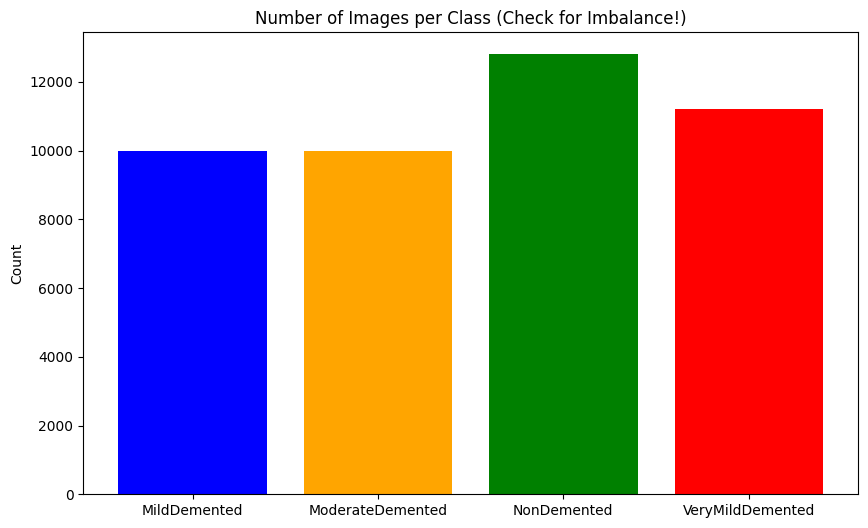

In [9]:
# 2. visualize this imbalance
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color=['blue', 'orange', 'green', 'red'])
plt.title('Number of Images per Class (Check for Imbalance!)')
plt.ylabel('Count')
plt.show()

"NonDemented" is a little higher (12,800 images) compared to "Moderate Demented" (10,000 images), which is about 28% more samples than the smallest classes. I found a mild data imbalance, so I applied Class Weighting to fix it.

Class weighting

In [10]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.array(list(class_counts.keys()))
y = []

# Build label list based on your counts
for cls, count in class_counts.items():
    y += [cls] * count

y = np.array(y)

weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y
)

class_weights = dict(zip(classes, weights))
print(class_weights)

{np.str_('MildDemented'): np.float64(1.1), np.str_('ModerateDemented'): np.float64(1.1), np.str_('NonDemented'): np.float64(0.859375), np.str_('VeryMildDemented'): np.float64(0.9821428571428571)}


Image Quality Assessment 

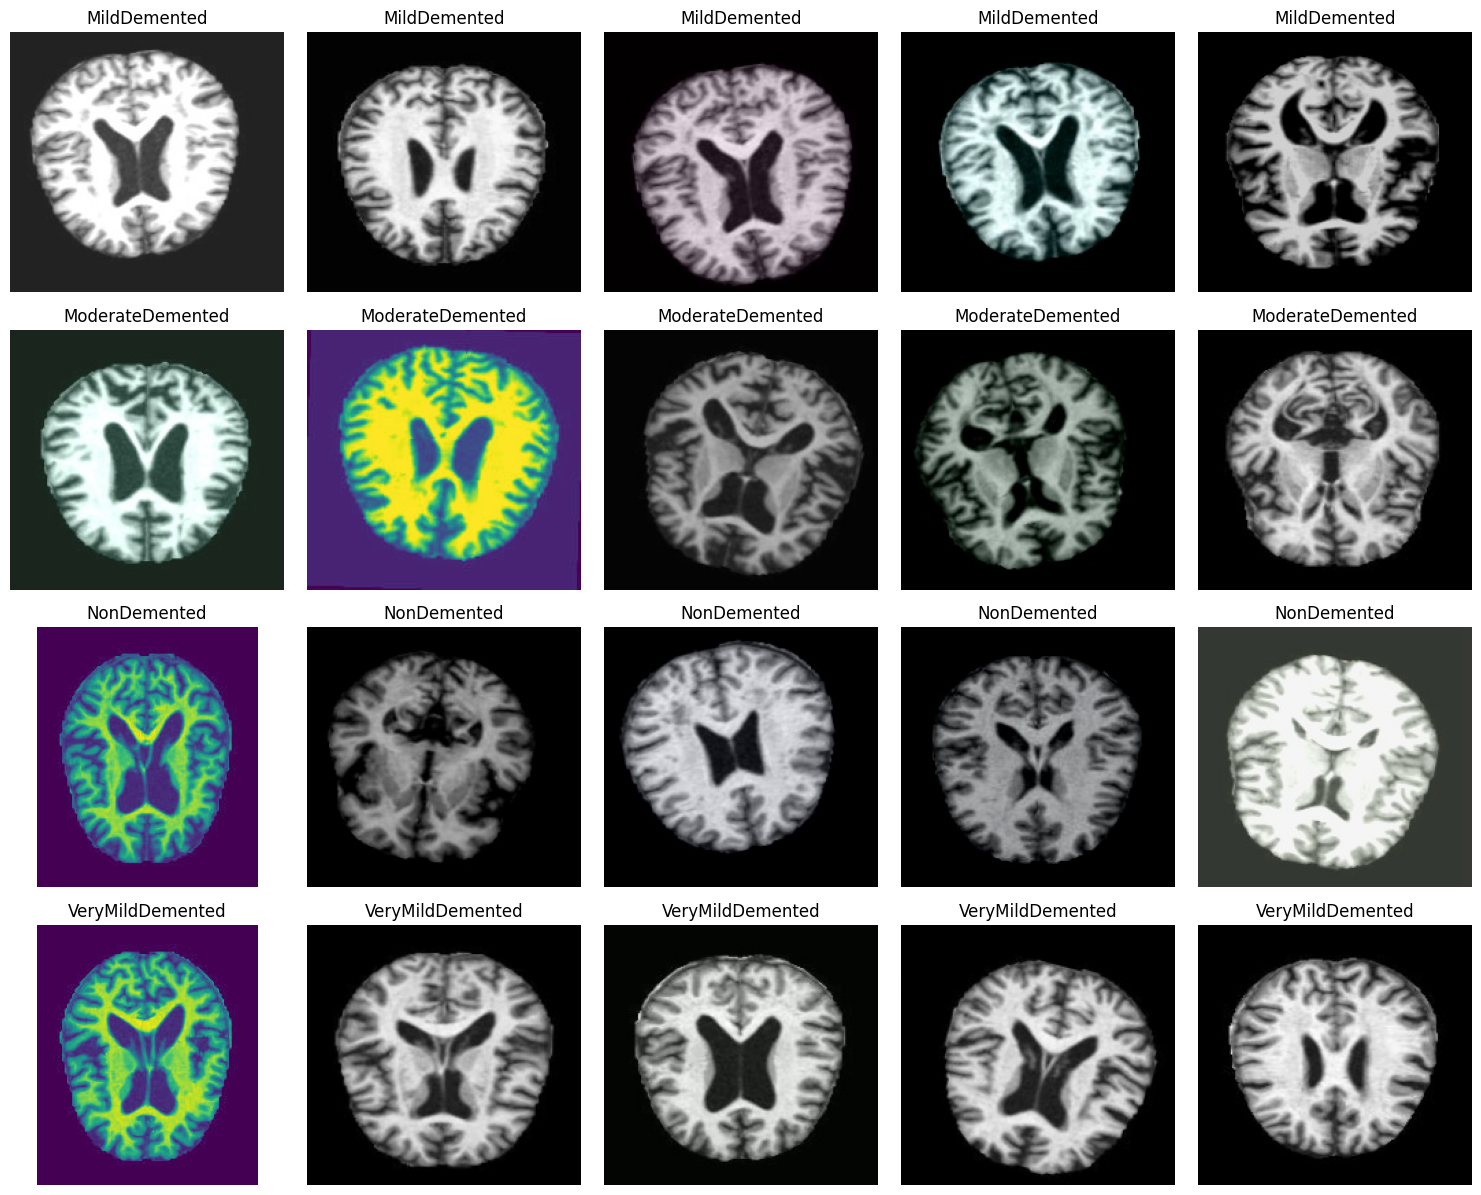

In [11]:
import random
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

classes = ["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"] # your class names

dataset_path = r"C:\Users\Lenovo\AlzheimerData"

# Count total number of images to determine subplot grid size
images_per_class = 5
total_images = len(classes) * images_per_class

plt.figure(figsize=(15, len(classes)*3))  # adjust figure size

img_number = 1  # subplot index

for cls in classes:
    class_folder = os.path.join(dataset_path, cls)
    images = os.listdir(class_folder)
    
    # Make sure there are at least 5 images
    if len(images) < images_per_class:
        print(f"Warning: {cls} has less than {images_per_class} images.")
        random_images = images  # use all available images
    else:
        random_images = random.sample(images, images_per_class)

    for img_name in random_images:
        img_path = os.path.join(class_folder, img_name)
        img = Image.open(img_path)

        plt.subplot(len(classes), images_per_class, img_number)
        plt.imshow(img)
        plt.title(cls)
        plt.axis("off")

        img_number += 1

plt.tight_layout()
plt.show()


HISTOGRAM ANALYSIS

In [12]:
def plot_histograms(dataset_path, images_per_class=20):
    classes = os.listdir(dataset_path)

    plt.figure(figsize=(12, 8))
    plt.suptitle("Pixel Intensity Distribution (Training Data)", fontsize=16)

    for idx, cls in enumerate(classes):
        class_folder = os.path.join(dataset_path, cls)
        images = os.listdir(class_folder)

        # Pick some images (not just one)
        sample_images = random.sample(images, min(images_per_class, len(images)))

        all_pixels = []  # This bucket will hold ALL pixel values

        for img_name in sample_images:
            img_path = os.path.join(class_folder, img_name)
            img = Image.open(img_path).convert("L")  # grayscale
            img_array = np.array(img)

            # Flatten image into a long list of numbers
            all_pixels.extend(img_array.flatten())

        # Plot one subplot per class
        plt.subplot(2, 2, idx + 1)
        plt.hist(all_pixels, bins=256)
        plt.title(cls)
        plt.xlabel("Pixel Intensity")
        plt.ylabel("Frequency")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


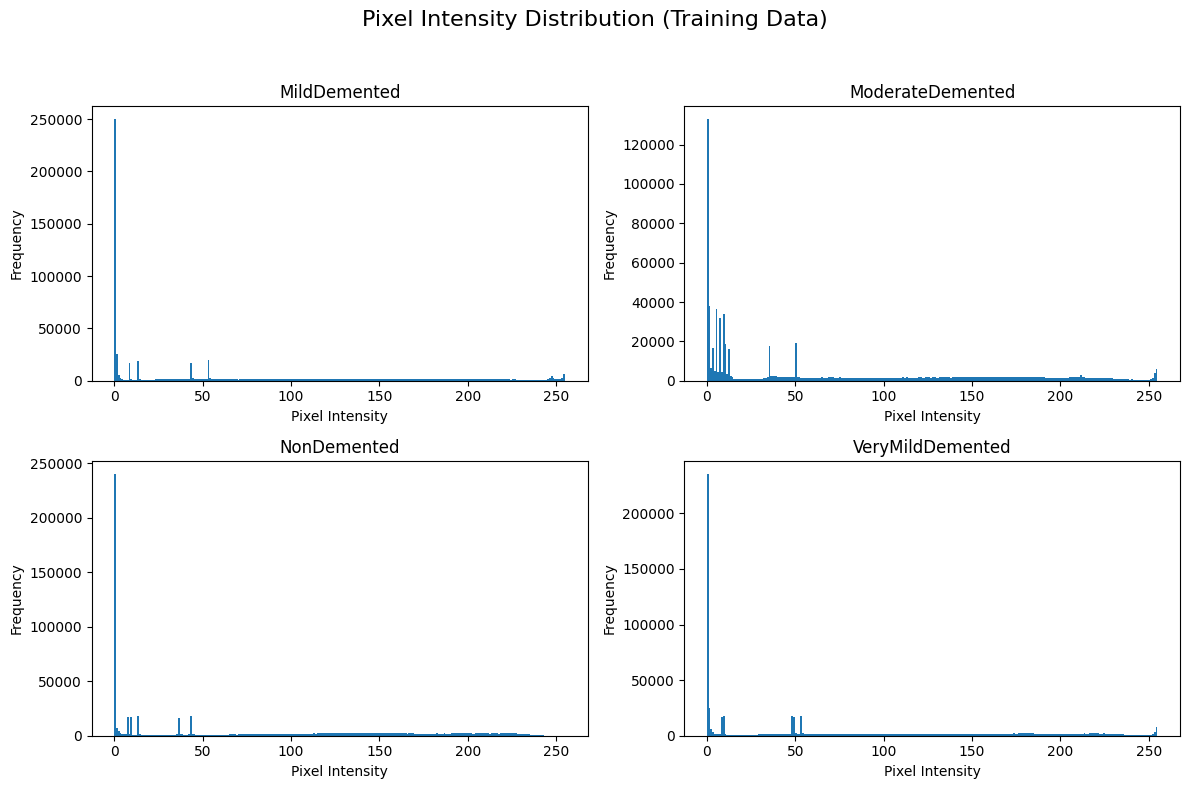

In [13]:
train_path = r"C:\Users\Lenovo\AlzheimerData"
plot_histograms(train_path)

FEATURE ENGINEERING

In [14]:
import os
import numpy as np
import pandas as pd

from PIL import Image
from skimage.feature import graycomatrix, graycoprops
from skimage.filters import sobel

In [15]:
#Load Image & Convert to Grayscale
#We turn the brain image into a 224×224 grid of numbers
def load_image(path):
    img = Image.open(path).convert("L")  # L = grayscale
    img = img.resize((224, 224))         # Same size for all images
    return np.array(img)

In [16]:
#Extract Smart Features
def extract_features(image_array):
    features = {}

    # 1. Brightness
    features["mean"] = np.mean(image_array)
    features["std"] = np.std(image_array)

    # 2. Texture (GLCM)
    glcm = graycomatrix(image_array, distances=[1], angles=[0], 
                        levels=256, symmetric=True, normed=True)

    features["texture_contrast"] = graycoprops(glcm, "contrast")[0, 0]
    features["texture_energy"] = graycoprops(glcm, "energy")[0, 0]
    features["texture_homogeneity"] = graycoprops(glcm, "homogeneity")[0, 0]

    # 3. Edges
    edge_img = sobel(image_array)
    features["edge_strength"] = np.mean(edge_img)

    return features

In [17]:
#Open image → extract brain features → store them in a table → repeat for all images
def process_dataset(dataset_path):
    data = []

    for label in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, label)

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)

            img = load_image(img_path)
            features = extract_features(img)

            features["label"] = label
            data.append(features)

    return pd.DataFrame(data)

In [18]:
dataset_path = r"C:\Users\Lenovo\AlzheimerData"

df = process_dataset(dataset_path)

print(df.head())

        mean        std  texture_contrast  texture_energy  \
0  54.806342  60.619263         92.692184        0.443716   
1  73.520667  84.477474        121.505445        0.418952   
2  78.809212  82.599373        115.112948        0.334563   
3  74.387556  77.074029        111.061719        0.350708   
4  68.111767  79.588980        121.574111        0.426283   

   texture_homogeneity  edge_strength         label  
0             0.534822       0.039231  MildDemented  
1             0.510352       0.048378  MildDemented  
2             0.452347       0.048399  MildDemented  
3             0.469445       0.047263  MildDemented  
4             0.513869       0.048425  MildDemented  


The model needs to be trained with more brain features such as, Brain structure, Shape, Texture,Region patterns etc. It will help the model learn better which will be closer to real medical patterns

DATA AUGMENTATION

In [19]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance

In [20]:
#This makes a “fake” image by slightly changing brightness
def augment_image(img):
    enhancer = ImageEnhance.Brightness(img)
    return enhancer.enhance(random.uniform(0.7, 1.3))

In [21]:
def compare_original_vs_augmented(dataset_path, class_name, samples=5):

    class_folder = os.path.join(dataset_path, class_name)
    images = os.listdir(class_folder)

    chosen_images = random.sample(images, samples)

    original_means = []
    augmented_means = []

    plt.figure(figsize=(10, 6))

    for i, img_name in enumerate(chosen_images):
        img_path = os.path.join(class_folder, img_name)

        # Load image
        original_img = Image.open(img_path).convert("L")

        # Make augmented version
        augmented_img = augment_image(original_img)

        # Convert to numbers
        orig_array = np.array(original_img)
        aug_array = np.array(augmented_img)

        # Save brightness values
        original_means.append(np.mean(orig_array))
        augmented_means.append(np.mean(aug_array))

        # Show images
        plt.subplot(samples, 2, i*2 + 1)
        plt.imshow(original_img, cmap="gray")
        plt.title("Original")
        plt.axis("off")

        plt.subplot(samples, 2, i*2 + 2)
        plt.imshow(augmented_img, cmap="gray")
        plt.title("Augmented")
        plt.axis("off")

    plt.suptitle(f"Original vs Augmented Images - {class_name}", fontsize=14)
    plt.show()

    # Plot brightness comparison
    plt.figure(figsize=(6, 4))
    plt.boxplot([original_means, augmented_means],tick_labels=["Original", "Augmented"])
    plt.title("Brightness Comparison")
    plt.ylabel("Mean Pixel Intensity")
    plt.show()

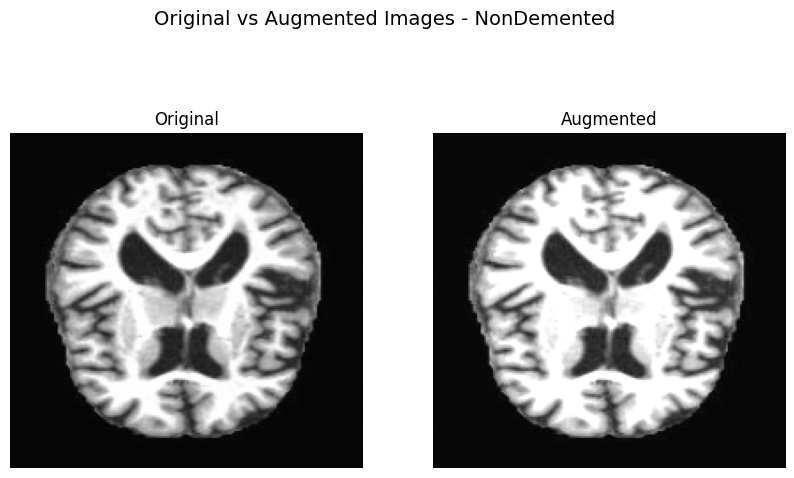

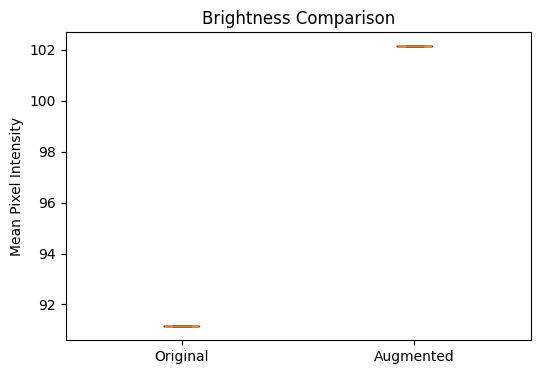

In [22]:
dataset_path = r"C:\Users\Lenovo\AlzheimerData"
compare_original_vs_augmented(dataset_path, "NonDemented", samples=1)

The model will see the same brain under different lighting conditions.

Brain shape is unchanged

Only brightness changed

Difference is small, not extreme

TRADITIONAL MACHINE LEARNING

In [ ]:
#Traditional ML does NOT understand pictures.Turn pictures, into numbers, then train a model on those numbers

In [23]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
#This turns an image into 4 numbers
def extract_features(img_path):
    img = Image.open(img_path).convert("L")
    img_array = np.array(img)

    return [
        np.mean(img_array),
        np.std(img_array),
        np.min(img_array),
        np.max(img_array)
    ]

In [25]:
dataset_path = r"C:\Users\Lenovo\AlzheimerData"

features = []
labels = []

for cls in os.listdir(dataset_path):
    class_folder = os.path.join(dataset_path, cls)

    for img_name in os.listdir(class_folder):
        if img_name.endswith(('.jpg', '.png', '.jpeg')):
            img_path = os.path.join(class_folder, img_name)

            feature_values = extract_features(img_path)

            features.append(feature_values)
            labels.append(cls)

In [26]:
df = pd.DataFrame(features, columns=["Mean", "Std", "Min", "Max"])
df["Class"] = labels

df.head()

,Mean,Std,Min,Max,Class
0,54.806474,60.670020,1,219,MildDemented
1,73.515158,84.518615,0,251,MildDemented
2,78.797747,82.666486,0,255,MildDemented
3,74.386526,77.109480,1,245,MildDemented
4,68.104895,79.642667,1,247,MildDemented


In [27]:
#Split Into Study Set and Exam Set
X = df[["Mean", "Std", "Min", "Max"]]
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [28]:
#Training the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [29]:
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

                  precision    recall  f1-score   support

    MildDemented       0.36      0.36      0.36      2039
ModerateDemented       0.44      0.45      0.44      2002
     NonDemented       0.47      0.50      0.49      2535
VeryMildDemented       0.32      0.30      0.31      2224

        accuracy                           0.41      8800
       macro avg       0.40      0.40      0.40      8800
    weighted avg       0.40      0.41      0.40      8800



The ACCURACY OF THE MODEL IS 41%.

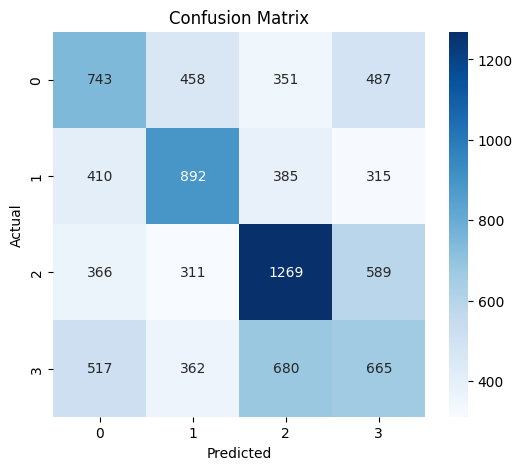

In [30]:
#Confusion Matrix (Visual Brain Check)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

This shows us that our model is our model is best at detecting NonDemented and is worst at detecting VeryMild and MildDemented. Traditional machine learning struggled to separate early-stage dementia classes due to subtle visual differences in MRI features, motivating the use of transfer learning for improved spatial feature extraction. This is only good as a baseline model.

TRANSFER LEARNING

In [31]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [32]:
img_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training"
)

val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation"
)

Found 35200 images belonging to 4 classes.
Found 8800 images belonging to 4 classes.


Resizes brains, Normalizes pixels (0 → 1 instead of 0 → 255), Automatically labels folders, Splits training & validation

In [33]:
#Load Smart Brain
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False

In [34]:
#Add Your Own Brain Layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
output = Dense(train_gen.num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)


In [35]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(train_gen, validation_data=val_gen, epochs=10)

Epoch 1/10
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 1031s 931ms/step - accuracy: 0.6595 - loss: 0.7621 - val_accuracy: 0.7006 - val_loss: 0.6919
Epoch 2/10
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 1072s 975ms/step - accuracy: 0.7335 - loss: 0.6051 - val_accuracy: 0.7141 - val_loss: 0.6589
Epoch 3/10
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 1020s 927ms/step - accuracy: 0.7707 - loss: 0.5296 - val_accuracy: 0.7748 - val_loss: 0.5238
Epoch 4/10
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 1036s 942ms/step - accuracy: 0.8007 - loss: 0.4685 - val_accuracy: 0.7997 - val_loss: 0.4895
Epoch 5/10
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 1060s 964ms/step - accuracy: 0.8289 - loss: 0.4147 - val_accuracy: 0.7969 - val_loss: 0.4778
Epoch 6/10
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 1056s 960ms/step - accuracy: 0.8487 - loss: 0.3669 - val_accuracy: 0.8292 - val_loss: 0.4025
Epoch 7/10
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 1068s 971ms/step - accuracy: 0.8647 - loss: 0.3298 - val_accuracy: 0.8509 - val_loss: 0.3681
Epoch 8/10
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 1887s 2s/step

The model learned meaningful brain image patterns and can classify new images with about 86% accuracy, showing good generalization and low overfitting.

In [36]:
import os
import shutil
import random

# Path to your dataset
base_dir = r"C:\Users\Lenovo\AlzheimerData"

# New folders
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

# Create folders if they don't exist
for folder in [train_dir, val_dir, test_dir]:
    os.makedirs(folder, exist_ok=True)

# Split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Loop through each class folder
for cls in os.listdir(base_dir):
    cls_path = os.path.join(base_dir, cls)

    # Skip folders we just created
    if cls in ["train", "val", "test"]:
        continue

    images = os.listdir(cls_path)
    random.shuffle(images)

    total = len(images)
    train_count = int(total * train_ratio)
    val_count = int(total * val_ratio)

    # Create class folders inside train/val/test
    for split_dir in [train_dir, val_dir, test_dir]:
        os.makedirs(os.path.join(split_dir, cls), exist_ok=True)

    # Move files
    for i, img in enumerate(images):
        src = os.path.join(cls_path, img)

        if i < train_count:
            dst = os.path.join(train_dir, cls, img)
        elif i < train_count + val_count:
            dst = os.path.join(val_dir, cls, img)
        else:
            dst = os.path.join(test_dir, cls, img)

        shutil.move(src, dst)

print("✅ Dataset successfully split into Train / Val / Test")

✅ Dataset successfully split into Train / Val / Test


In [37]:
#Create Your Test Generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    r"C:\Users\Lenovo\AlzheimerData\test",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

Found 6601 images belonging to 4 classes.


In [38]:
#Evaluate Model
test_loss, test_accuracy = model.evaluate(test_gen)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

207/207 ━━━━━━━━━━━━━━━━━━━━ 165s 797ms/step - accuracy: 0.9024 - loss: 0.2426
Test Loss: 0.24256864190101624
Test Accuracy: 0.9024389982223511


TEST ACCURACY IS 90%. THIS TELLS US THAT OUT OF EVERY 10 NEW MRI IMAGES, OUR MODEL CORRECTLY CLASSIFIES ABOUT 9 OUT OF THEM. OUR MODEL HAS LEARNED TO: 

SHAPE PATTERNS OF THE BRAIN

TEXTURE DIFFERENCES BETWEEN DEMENTIA sSTAGES

VVISUAL MARKERS THATSEPERATE HEALTHY VS AFFECTED SCANS

Confusion Matrix

In [39]:
#Generate Predictions
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Get true labels
y_true = test_gen.classes

# Get model predictions
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

207/207 ━━━━━━━━━━━━━━━━━━━━ 166s 778ms/step


In [40]:
#print Classification Report
print(classification_report(y_true, y_pred_classes, target_names=test_gen.class_indices.keys()))

                  precision    recall  f1-score   support

    MildDemented       0.93      0.92      0.92      1500
ModerateDemented       0.99      1.00      0.99      1500
     NonDemented       0.83      0.94      0.88      1920
VeryMildDemented       0.90      0.76      0.83      1681

        accuracy                           0.90      6601
       macro avg       0.91      0.90      0.91      6601
    weighted avg       0.91      0.90      0.90      6601



This tells us that our model has a strong overall learning and has a good generalization to new data. The model is strong for screening, but early-stage detection needs improvement. The main limitation of this model is VeryMild vs NonDemented confusion.

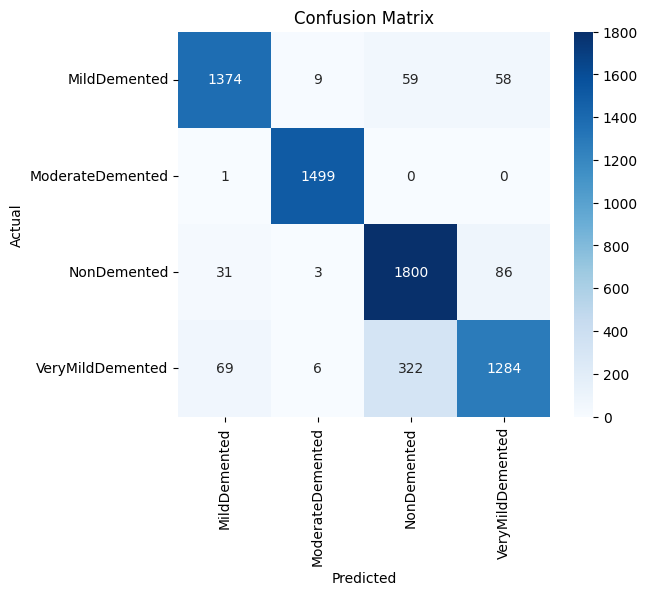

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=test_gen.class_indices.keys(),
            yticklabels=test_gen.class_indices.keys(),
            cmap="Blues")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [42]:
#saving the model
model.save("alzheimers_brain_model.keras")

FINE-TUNING THE MODEL

In [43]:
#Unfreeze Top Layers
base_model.trainable = True

# Freeze most layers, unfreeze last 30
for layer in base_model.layers[:-30]:
    layer.trainable = False

In [44]:
#Recompile the model
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.0001),  # small brain steps
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [45]:
#Recreate Your Generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_gen = train_datagen.flow_from_directory(
    r"C:\Users\Lenovo\AlzheimerData\train",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

Found 30799 images belonging to 4 classes.


In [46]:
#Create Validation Generator
val_datagen = ImageDataGenerator(rescale=1./255)

val_gen = val_datagen.flow_from_directory(
    r"C:\Users\Lenovo\AlzheimerData\val",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

Found 6600 images belonging to 4 classes.


In [47]:
#Train the model
history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5
)

Epoch 1/5
963/963 ━━━━━━━━━━━━━━━━━━━━ 1575s 2s/step - accuracy: 0.6786 - loss: 0.8753 - val_accuracy: 0.7114 - val_loss: 0.9080
Epoch 2/5
963/963 ━━━━━━━━━━━━━━━━━━━━ 1429s 1s/step - accuracy: 0.7833 - loss: 0.4992 - val_accuracy: 0.8229 - val_loss: 0.4220
Epoch 3/5
963/963 ━━━━━━━━━━━━━━━━━━━━ 1206s 1s/step - accuracy: 0.8363 - loss: 0.3925 - val_accuracy: 0.8315 - val_loss: 0.4641
Epoch 4/5
963/963 ━━━━━━━━━━━━━━━━━━━━ 1244s 1s/step - accuracy: 0.8752 - loss: 0.3102 - val_accuracy: 0.7535 - val_loss: 1.0192
Epoch 5/5
963/963 ━━━━━━━━━━━━━━━━━━━━ 1267s 1s/step - accuracy: 0.9020 - loss: 0.2456 - val_accuracy: 0.8974 - val_loss: 0.2733


Our Training accuracy is 90% and validation accuracy is 89%. This tells us that the model did not overfit. The mdeical understanding of the model improved. 

In [49]:
import matplotlib.pyplot as plt

# Get accuracy and loss from both training phases
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

# Epoch numbers
epochs = range(1, len(acc) + 1)

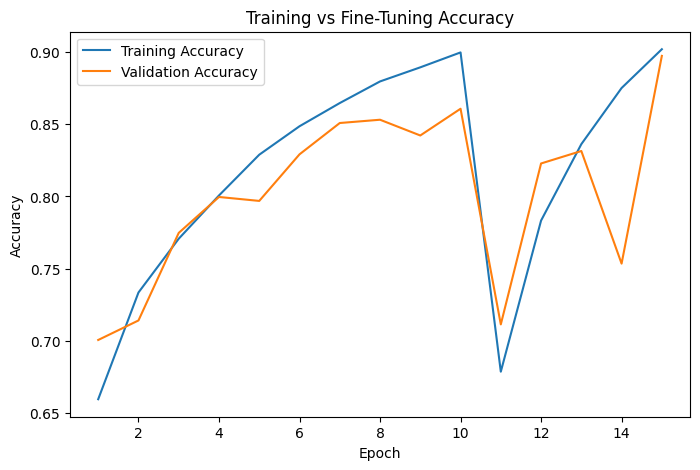

In [51]:
#Plot Accuracy
plt.figure(figsize=(8,5))

plt.plot(epochs, acc, label="Training Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")

plt.title("Training vs Fine-Tuning Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

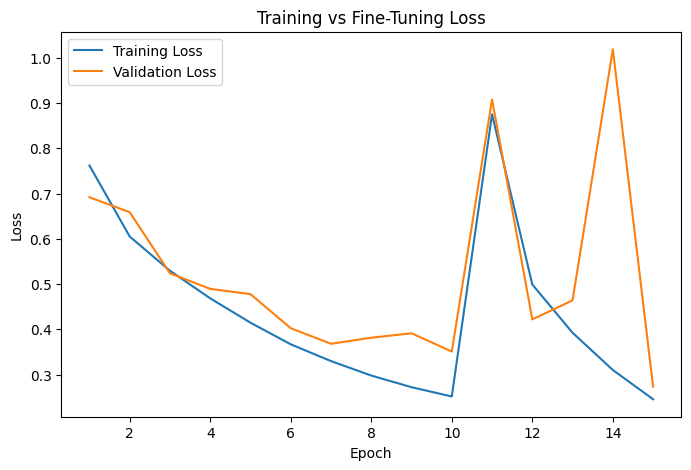

In [53]:
#Plot Loss
plt.figure(figsize=(8,5))

plt.plot(epochs, loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")

plt.title("Training vs Fine-Tuning Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

The model showed consistent improvement during the fine-tuning phase, as evidenced by an increase in validation accuracy and a decrease in validation loss. This indicates that the pre-trained network adapted effectively to the domain-specific features of brain MRI images without significant overfitting.

In [56]:
#Saving the final model
model.save("alzheimers_model_final.keras")

In [57]:
import os
print(os.getcwd())

C:\Users\Lenovo
